# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

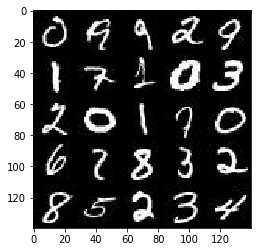

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

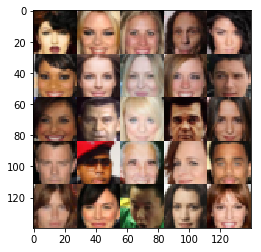

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):       
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())        
        # No batch normalization on first layer
        # x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        # 8x8x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 2x2x256
        
        # flatten into 1
        flatten = tf.reshape(x3, (-1, 2*2*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    
    return (out, logits)
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)        
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # No batch normalization on last layer
        # x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 32x32x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                           labels=tf.ones_like(d_model_real)*(1 - 0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                           labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [x for x in t_vars if x.name.startswith('generator')]
    d_vars = [x for x in t_vars if x.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    
    samples, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Expand range of real values from [-0.5,0.5] to [-1,1]
                batch_images = batch_images * 2.0

                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                steps += 1
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3913... Generator Loss: 0.0256
Epoch 1/2... Discriminator Loss: 1.5716... Generator Loss: 6.8221
Epoch 1/2... Discriminator Loss: 3.0200... Generator Loss: 0.1499
Epoch 1/2... Discriminator Loss: 1.7177... Generator Loss: 4.3388
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 1.9042
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 3.7550
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 2.1589
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 2.3272
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 0.6673... Generator Loss: 1.7881


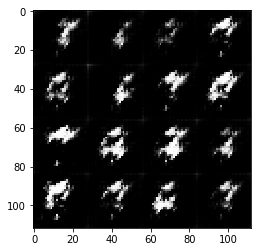

Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 2.2149
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.4190
Epoch 1/2... Discriminator Loss: 0.7294... Generator Loss: 2.2933
Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 3.0073
Epoch 1/2... Discriminator Loss: 0.6701... Generator Loss: 2.8599
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.2453
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 2.0835
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 0.8616... Generator Loss: 2.4217


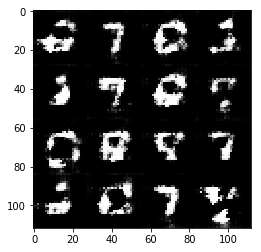

Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 2.1452
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.9943
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.4636
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 1.5228
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.2904


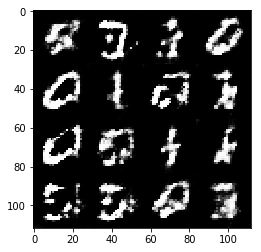

Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 0.9398... Generator Loss: 1.1185
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.6539
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 2.1137
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 1.8781
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 1.5635
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 1.3869


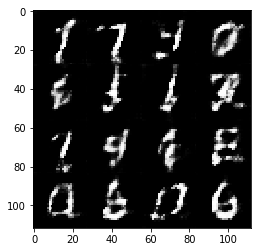

Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.6499
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 1.5212... Generator Loss: 2.1811
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 1.3932
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 1.5784
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 1.6636


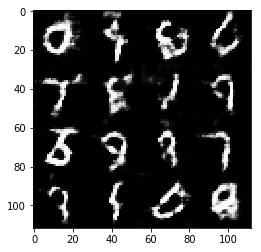

Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.7169
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 1.3343
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.5126
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.8325


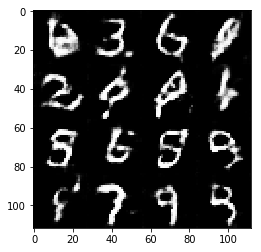

Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.1526... Generator Loss: 0.9460
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 0.9160


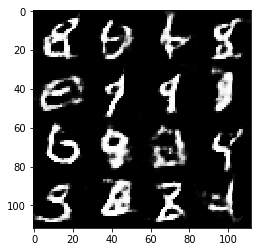

Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 1.4925
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 1.5328
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.9386
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 1.1329
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 1.5231
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.2156


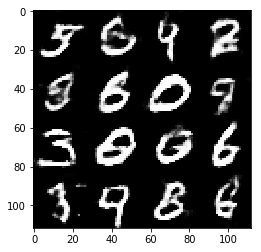

Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 1.7032
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 1.7455
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 1.2938... Generator Loss: 1.7087
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 0.4123
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.7747


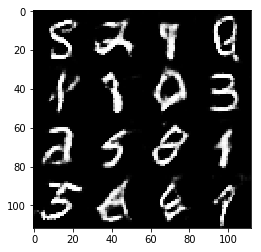

Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 0.9027
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.8489


In [44]:
batch_size = 128
z_dim = 128
learning_rate = 0.0006
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 3.0412
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 3.2480
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.3451
Epoch 1/1... Discriminator Loss: 1.8059... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.2181


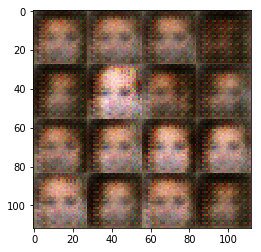

Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.9488


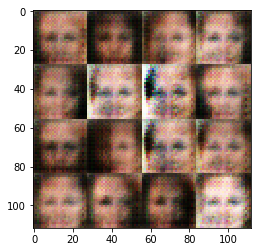

Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7789


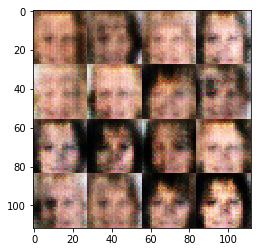

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7911


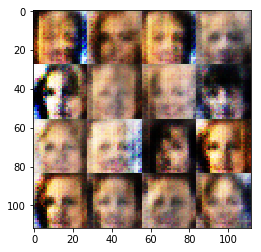

Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.9875


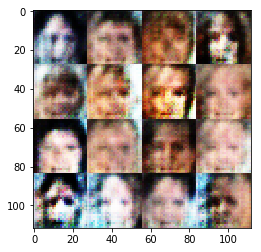

Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.9985


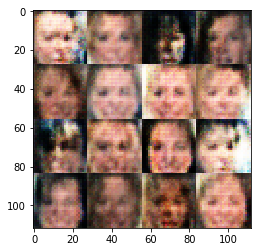

Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.7501


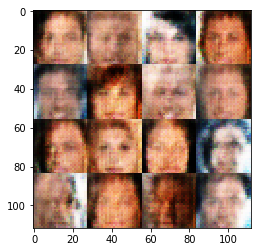

Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.9140


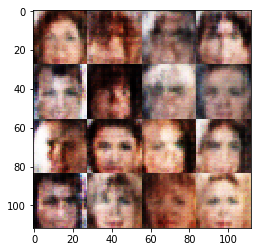

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8042


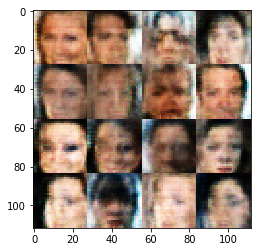

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.9064


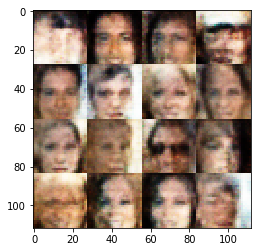

Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 1.2368
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9031


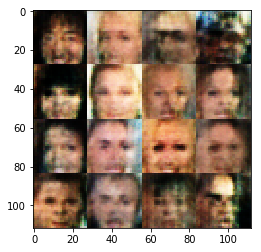

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7141


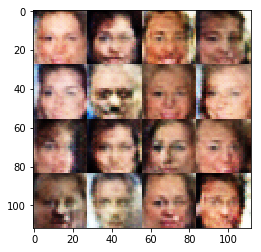

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7977


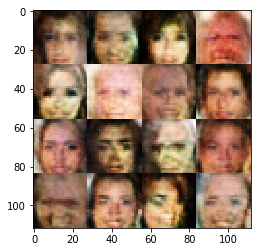

Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8397


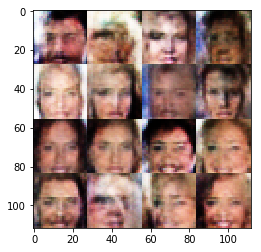

Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8196


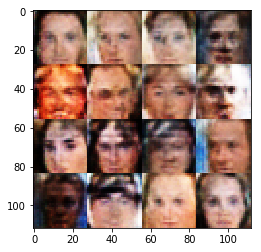

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9174


In [45]:
batch_size = 128
z_dim = 128
learning_rate = 0.0006
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.